# Кодрян М.С. ПЗАД, лекция 4 о функционалах качества и-тогдалие...

## RMSE vs MSE


La question m'a déjà intéressée pendant la leçon... Ой, тьфу ты, раскладку не поменял. Да, так вот, тема меня заинтересовала еще во время урока. Попробуем разобраться в ней.

Итак, общая постановка... Ладно, все мы люди взрослые, давайте непосредственно к оптимизационной задаче без прелюдий:
$$MSE = \frac{1}{n} \sum_{i=1}^n (y_i - a_i(w))^2 \longrightarrow \min_{w \in \mathbb{R}^d}$$
$$RMSE = \sqrt{MSE} \longrightarrow \min_{w \in \mathbb{R}^d}$$

Всякому млекопитающему из рода евразийских ежей семейства ежовых абсолютно очевидным представляется тот факт, что множества решений обеих оптимизационных задач в силу монотонности преобразия между ними совпадают. Окей, круто, сказали бы математики-теоретики и пошли дальше проверять доказательство Великой Теоремы Ферма. Но мы ~~жалкие черви~~ прикладники задаемся еще одним немаловажным вопросом: а **как** решать-то? Что, когда и где удобнее?

Давайте разбираться...

Для начала перепишем задачи в более *простом и понятном* виде. Пусть $g: \mathbb{R}^d \rightarrow \mathbb{R}^n, g(w)_i = \frac{1}{\sqrt{n}} (y_i - a_i(w))$. Тогда:
$$MSE = \Vert g(w) \Vert^2 \longrightarrow \min_{w \in \mathbb{R}^d}$$
$$RMSE = \Vert g(w) \Vert \longrightarrow \min_{w \in \mathbb{R}^d}$$

А что с градиентами?
$$\nabla_w MSE = 2 J_{g(w)}^T g(w)$$
$$\nabla_w RMSE = J_{g(w)}^T \frac{g(w)}{\Vert g(w)\Vert}$$

Уууу, Якобианы (ну, то есть матрицы Якоби, конечно же, что за пренебрежение к терминам)... Страшно, конечно, но уже закрадываются подозрения в том, что у RMSE градиент *как бэ* инвариантен к величине $\Vert g(w) \Vert$: оператор $J_{g(w)}^T$ всегда применяется к нормированному вектору (за исключением случая, когда $g(w) = 0$, то есть мы сошлись к решению). 

Давайте лучше рассмотрим простой частный случай $d=n, a_i(w) = w_i$. В нем и будем оставаться далее ~~(как в уютненьком манямирке, где никакие трудности и невзгоды оптимизационных задач реального мира нам не страшны)~~. Опа, тогда $J_{g(w)} = - \frac{1}{\sqrt{n}} I_n$, и:
$$\nabla_w MSE = 2 J_{g(w)}^T g(w) = -\frac{2}{\sqrt{n}} g(w)$$
$$\nabla_w RMSE = J_{g(w)}^T \frac{g(w)}{\Vert g(w)\Vert} = -\frac{1}{\sqrt{n}} \frac{g(w)}{\Vert g(w)\Vert}$$

Теперь, когда славная матрица Якоби у нас скалярная, мы можем точно сказать, что градиент RMSE не затухает, а его норма всегда равна $\frac{1}{\sqrt{n}}$. В то же время норма градиента MSE пропорциональна норме $g(w)$, поэтому градиент будет затухать по мере приближения $g(w)$ к нулю.

Теперь о методах оптимизации. 

Исходя из наших выводов, можно заключить, что GD с константным шагом почти всегда не подходит для RMSE-случая (ну, за исключением специального или удачного выбора начального приближения/константы). Если нам не повезет, и мы не сойдемся к точному решению за конечное число шагов, нам придется бесконечно бродить в его окрестности, сетуя на слишком большой и неадаптивный размер наших шагов. У MSE, как было оговорено, такой проблемы нет. 

В другую сторону, стратегия с константным шаг вполне подходит для мимимизации MSE, в то же время слишком робкие шажки с слишком быстрым их затуханием могут привести к тому, что до оптимума мы либо не дойдем, либо будем идти слишком долго~~, устанем, упадем и умрем в поле~~.

Окей, мистер Питон, помоги мне проиллюстрировать этот бред.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
%matplotlib inline
%config InlineBackend.figure_format = 'svg' 

In [2]:
from pylab import rcParams
rcParams['figure.figsize'] = 8, 6

In [3]:
def MSE(y, w):
    return np.mean(np.sum((y - w) ** 2))

def RMSE(y, w):
    return np.sqrt(MSE(y, w))

def g(y, w):
    return (1 / np.sqrt(y.size)) * (y - w)

def grad_MSE(y, w):
    return - (2 / np.sqrt(y.size)) * g(y, w)

def grad_RMSE(y, w):
    g_norm = np.linalg.norm(g(y, w))
    return grad_MSE(y, w) / (2 * g_norm) if g_norm > 0 else 0

In [4]:
y = np.random.randn(100)
w_0 = np.zeros(100)

### Constant step GD

In [5]:
mse, rmse, grad_mse, grad_rmse = [], [], [], []
w_mse, w_rmse = [w_0], [w_0]
c = 1

for i in range(1001):
    w_mse_ = w_mse[-1]
    mse.append(MSE(y, w_mse_))
    grad_w_mse = grad_MSE(y, w_mse_)
    grad_mse.append(grad_w_mse)
    w_mse.append(w_mse_ - c * grad_w_mse)
    
    w_rmse_ = w_rmse[-1]
    rmse.append(RMSE(y, w_rmse_))
    grad_w_rmse = grad_RMSE(y, w_rmse_)
    grad_rmse.append(grad_w_rmse)
    w_rmse.append(w_rmse_ - c * grad_w_rmse)

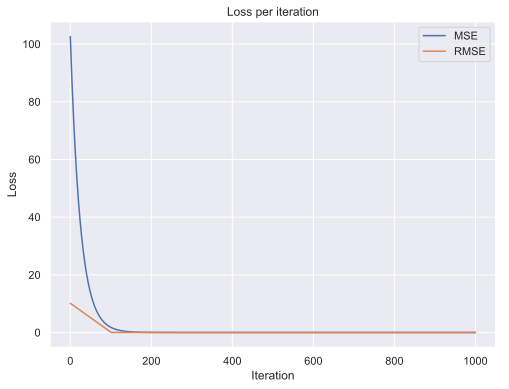

In [6]:
plt.plot(mse, label="MSE")
plt.plot(rmse, label="RMSE")
plt.title("Loss per iteration")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.show()

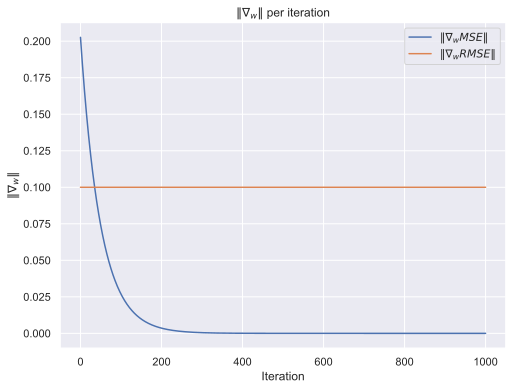

In [7]:
plt.plot([np.linalg.norm(g) for g in grad_mse], label=r"$\Vert \nabla_w MSE \Vert$")
plt.plot([np.linalg.norm(g) for g in grad_rmse], label=r"$\Vert \nabla_w RMSE \Vert$")
plt.title(r"$\Vert \nabla_w \Vert$ per iteration")
plt.xlabel("Iteration")
plt.ylabel(r"$\Vert \nabla_w \Vert$")
plt.legend()
plt.show()

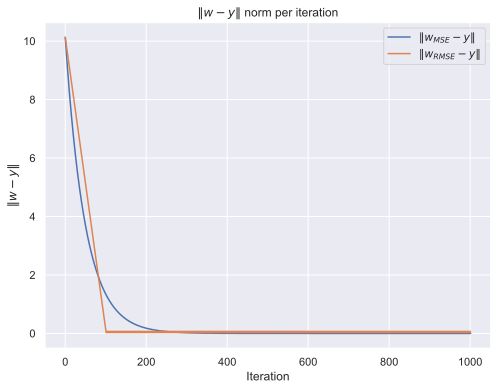

In [8]:
plt.plot([np.linalg.norm(w - y) for w in w_mse], label=r"$\Vert w_{MSE} - y \Vert$")
plt.plot([np.linalg.norm(w - y) for w in w_rmse], label=r"$\Vert w_{RMSE} - y \Vert$")
plt.title(r"$\Vert w - y \Vert$ norm per iteration")
plt.xlabel("Iteration")
plt.ylabel(r"$\Vert w - y \Vert$")
plt.legend()
plt.show()

In [9]:
np.linalg.norm(w_mse_ - y)  # <-- Very close to solution

1.704839194130087e-08

In [10]:
np.linalg.norm(w_rmse_ - y)  # <-- Still not that close

0.0700400311655751

### Decaying step GD

In [11]:
mse, rmse, grad_mse, grad_rmse = [], [], [], []
w_mse, w_rmse = [w_0], [w_0]
c = 10
gamma = 0.9

for i in range(1001):
    w_mse_ = w_mse[-1]
    mse.append(MSE(y, w_mse_))
    grad_w_mse = grad_MSE(y, w_mse_)
    grad_mse.append(grad_w_mse)
    w_mse.append(w_mse_ - c * grad_w_mse)
    
    w_rmse_ = w_rmse[-1]
    rmse.append(RMSE(y, w_rmse_))
    grad_w_rmse = grad_RMSE(y, w_rmse_)
    grad_rmse.append(grad_w_rmse)
    w_rmse.append(w_rmse_ - c * grad_w_rmse)
    
    c *= gamma

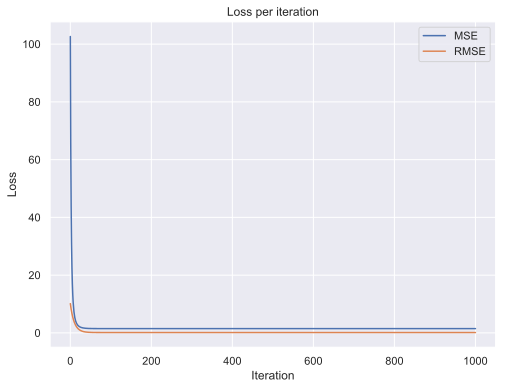

In [12]:
plt.plot(mse, label="MSE")
plt.plot(rmse, label="RMSE")
plt.title("Loss per iteration")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.show()

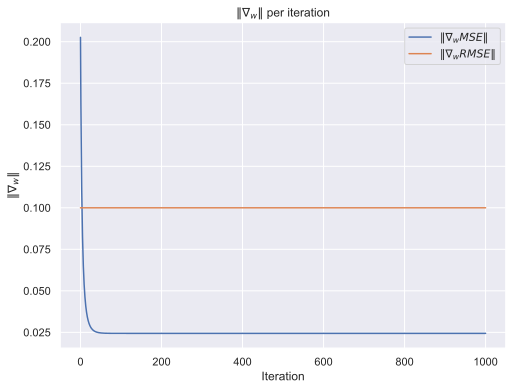

In [13]:
plt.plot([np.linalg.norm(g) for g in grad_mse], label=r"$\Vert \nabla_w MSE \Vert$")
plt.plot([np.linalg.norm(g) for g in grad_rmse], label=r"$\Vert \nabla_w RMSE \Vert$")
plt.title(r"$\Vert \nabla_w \Vert$ per iteration")
plt.xlabel("Iteration")
plt.ylabel(r"$\Vert \nabla_w \Vert$")
plt.legend()
plt.show()

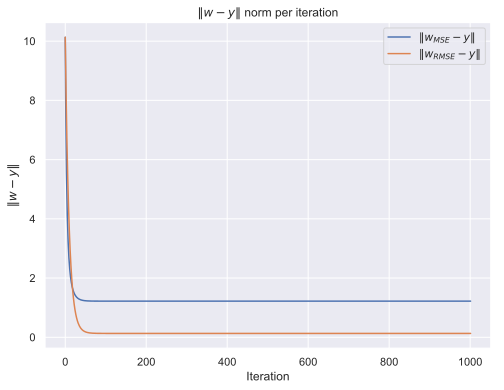

In [14]:
plt.plot([np.linalg.norm(w - y) for w in w_mse], label=r"$\Vert w_{MSE} - y \Vert$")
plt.plot([np.linalg.norm(w - y) for w in w_rmse], label=r"$\Vert w_{RMSE} - y \Vert$")
plt.title(r"$\Vert w - y \Vert$ norm per iteration")
plt.xlabel("Iteration")
plt.ylabel(r"$\Vert w - y \Vert$")
plt.legend()
plt.show()

In [15]:
np.linalg.norm(w_mse_ - y)  # <-- Wait, we did not succeed?!

1.2202402352210553

In [16]:
np.linalg.norm(w_rmse_ - y)  # <-- WOW! Much better here!

0.12995996883443126

Вот такие пирожные...

Кстати, за счет свойства адаптивности под норму $g(w)$ мимимизация MSE при начальных приближениях, слишком далеких от оптимума, может быть эффективнее, чем RMSE. Поэтому какие-нибудь гибридные методы (сначала минимизируем MSE с каким-нибудь константным шагом, потом RMSE с адаптивным) могут быть реально крутыми. В конечном итоге, решения обеих задач совпадают, а значит, нам ничто не мешает объединять их! Но об этом как-нибудь в другой раз...